In [1]:
%matplotlib notebook
import os, sys
import logging
import random
import h5py
import shutil
import time
import argparse
import numpy as np
import sigpy.plot as pl
import torch
import sigpy as sp
import torchvision
from torch import optim
from tensorboardX import SummaryWriter
from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib
# import custom libraries
from utils import transforms as T
from utils import subsample as ss
from utils import complex_utils as cplx
from utils.resnet2p1d import generate_model
from utils.flare_utils import roll
from utils import data_ut as dut
# import custom classes
from utils.datasets import SliceData
from subsample_fastmri import MaskFunc
from MoDL_single import UnrolledModel
import argparse
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from models.SAmodel import MyNetwork
from models.Unrolled import Unrolled
from ImageFusion_Dualbranch_Fusion.densefuse_net import DenseFuseNet
from ImageFusion_Dualbranch_Fusion.channel_fusion import channel_f as channel_fusion
from torchvision.transforms.functional import adjust_contrast 
from fastmri.data import transforms, subsample
from RCAN import CombinedNetwork
import scipy.ndimage
from scipy.ndimage import binary_closing
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
%load_ext autoreload
%autoreload 0

In [2]:
!pwd

/home/tal/docker/MoDLsinglechannel/modl_singlechannel_reference


In [3]:
!which python3

/home/tal/docker/dockvenv/bin/python3


In [4]:
# Path to your NIfTI file
nii_file_target = './test_data/patient29b/T1_week152reg.nii'
img_target = nib.load(nii_file_target)
nii_file_ref = './test_data/patient29b/T1_week165regT1_week152.nii'
img_ref = nib.load(nii_file_ref)
target = img_target.get_fdata()[...,20]
reference = img_ref.get_fdata()[...,20]

random_phase = torch.angle(T.random_map((1,256,160), 'cpu',kspace_radius_range=(0.001, 0.001))) 
target = target * (torch.exp(1j * random_phase)).numpy() 
target = target.squeeze(0)
target_torch = cplx.to_tensor(target).float() 
reference_torch = cplx.to_tensor(reference).float() 
reference_kspace_torch = T.fft2(reference_torch)
reference_kspace = cplx.to_numpy(reference_kspace_torch)
#reference_kspace_torch = T.kspace_cut(reference_kspace_torch, 0.67,0.67)
#reference_kspace = cplx.to_numpy(reference_kspace_torch)
#reference_torch = T.ifft2(reference_kspace_torch)
#reference = cplx.to_numpy(reference_torch)
kspace_torch = T.fft2(target_torch)
#kspace_torch = T.kspace_cut(kspace_torch, 0.67,0.67)
#target_torch = T.ifft2(kspace_torch)
target = cplx.to_numpy(target_torch)
kspace = cplx.to_numpy(kspace_torch)
# Print the shape of the data to verify
print(target_torch.shape)
mask2 = sp.mri.poisson((256,160),5, calib=(18,14), dtype=float, crop_corner=False, return_density=True, seed=0, max_attempts=6, tol=0.01)
mask2[128-10:128+9,80-8:80+7] = 1
mask_torch = torch.stack([torch.tensor(mask2).float(),torch.tensor(mask2).float()],dim=2)

mask_torch = T.kspace_crop(mask_torch,0.67)
kspace_torch = T.awgn_torch(kspace_torch,10,L=1)
kspace_torch = T.kspace_crop(kspace_torch,0.67)

print(kspace_torch.shape)
print(mask_torch.shape)
kspace_torch = kspace_torch*mask_torch

s = (256/1.5)*(160/1.5)
print((torch.sum(mask_torch))/s)

torch.Size([256, 160, 2])
torch.Size([256, 160, 2])
torch.Size([256, 160, 2])
tensor(0.6423)


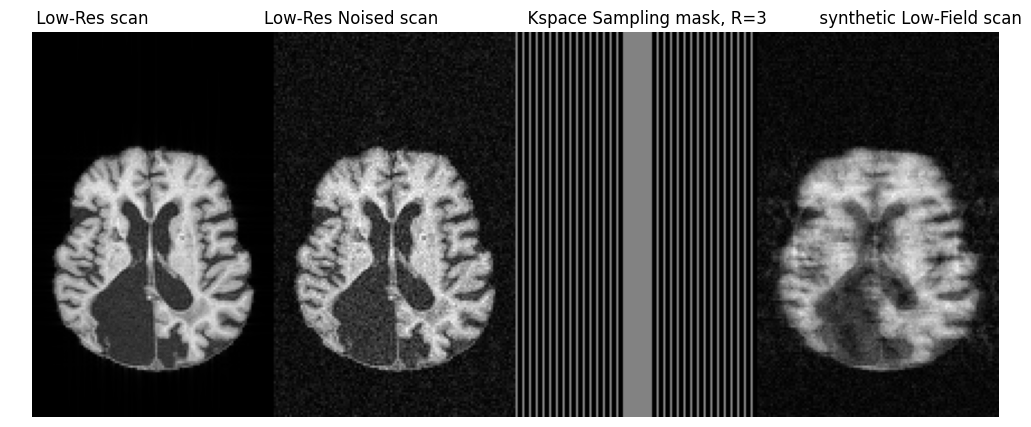

Mask torch size: (172, 108)
Acceleration factor R: 0.4074074074074074


In [5]:
im_lowres = abs(sp.ifft(sp.resize(sp.resize(kspace,(256,24)),(256,160))))
magnitude_vals = im_lowres.reshape(-1)
k = int(round(0.05 * magnitude_vals.shape[0]))
scale = magnitude_vals[magnitude_vals.argsort()[::-1][k]]
kspace = kspace/scale
target = target/scale

# Apply kspace crop on target
target_torch = cplx.to_tensor(target)
target_torch = T.ifft2( T.kspace_cut(T.fft2(target_torch),0.67,0.67))
# For plot
kspace_HR = np.abs(cplx.to_numpy(T.fft2(cplx.to_tensor(target))))
kspace_LR =cplx.to_numpy( T.kspace_crop(T.fft2( cplx.to_tensor(target)),0.67))
target_HR = target
target_LR = cplx.to_numpy(T.ifft2( T.kspace_crop(T.fft2( cplx.to_tensor(target)),0.67)))
target = cplx.to_numpy(target_torch)
# Convert everything from numpy arrays to tensors
kspace_torch = cplx.to_tensor(kspace).float()
kspace_torch = T.awgn_torch(kspace_torch,10,L=1)
kspace_noised = kspace_torch.clone()
kspace_noised = T.kspace_cut(kspace_noised,0.67,0.67)
kspace_torch = T.kspace_cut(kspace_torch,0.67,0.67)
target_torch = cplx.to_tensor(target).float()

### Reference addition ###
im_lowres_ref = abs(sp.ifft(sp.resize(sp.resize(reference_kspace,(256,24)),(256,160))))
magnitude_vals_ref = im_lowres_ref.reshape(-1)
k_ref = int(round(0.05 * magnitude_vals_ref.shape[0]))
scale_ref = magnitude_vals_ref[magnitude_vals_ref.argsort()[::-1][k_ref]]
reference = reference / scale_ref
reference_torch = cplx.to_tensor(reference).float()
reference_torch_kspace = T.fft2(reference_torch)
reference_torch_kspace = T.kspace_cut(reference_torch_kspace,0.67,0.67)
reference_torch = T.ifft2(reference_torch_kspace)
"""
fig, axs = plt.subplots(1, 1, figsize=(5, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(np.abs(cplx.to_numpy(mask_torch)), cmap='gray')
plt.show()
"""
#kspace_torch = kspace_torch*mask_torch

from fastmri.data import transforms, subsample
def get_mask_func(factor):
    center_fractions = 0.08 * 4/factor # RandomMaskFunc
    mask_func = subsample.EquiSpacedMaskFunc(
    center_fractions=[center_fractions],
    accelerations=[factor], 
    )
    return mask_func
mask_func = get_mask_func(3)
kspace_torch = transforms.apply_mask(kspace_torch, mask_func)[0]

concat = np.concatenate((target,cplx.to_numpy(T.ifft2(kspace_noised)),np.abs(cplx.to_numpy(kspace_torch))!=0,cplx.to_numpy(T.ifft2(kspace_torch))),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(20, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(np.abs(concat), cmap='gray')
#im1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
plt.title('     Low-Res scan                      Low-Res Noised scan                 Kspace Sampling mask, R=3          synthetic Low-Field scan')
plt.axis('off')
plt.show()
"""
concat = np.concatenate((target_HR,target_LR),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(6, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(np.abs(concat), cmap='gray')
#im1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
plt.title(' High-Res scan (1x1[mm])        Low-Res scan (1.5x1.5[mm])   ')
plt.axis('off')
plt.show()

concat = np.concatenate((kspace_HR,kspace_LR),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(6, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(np.log(np.abs(concat)), cmap='gray')
#im1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
plt.title(' High-Res kspace (1x1[mm])        Low-Res kspace (1.5x1.5[mm])   ')
plt.axis('off')
plt.show()
"""
mask_np = np.abs(cplx.to_numpy(kspace_torch))!=0
print(f'Mask torch size: {mask_np.shape}')
s = (172)*(108)
print(f'Acceleration factor R: {np.sum(mask_np)/s}')

In [6]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [7]:
#Hyper parameters
params = Namespace()
#params.data_path = "./registered_data/patient23b/"
params.data_path = "./registered_data/"
params.batch_size = 2
params.num_grad_steps = 1 #4
params.num_cg_steps = 8 #8
params.share_weights = True
params.modl_lamda = 0.05
params.lr = 0.00001
#params.lr = 0.0001
params.weight_decay = 0
params.lr_step_size = 7
params.lr_gamma = 0.1
params.epoch = 61
params.reference_mode = 1
params.reference_lambda = 0.1

In [8]:

#3checkpoint_file = "./L2_checkpoints_poisson_x2_SAunrolledPlug/model_5.pt"
checkpoint_file_vit = "./L2_checkpoints_poisson_x2_UnrolledFusionNetViT_finetuneall_LR/model_15.pt"  
checkpoint_file_fine = "./L2_checkpoints_poisson_x2_ViT_LR_tests/model_10.pt"
checkpoint_file_fine_test2 = "./L2_checkpoints_poisson_x2_ViT_LR_tests2/model_10.pt"
checkpoint_file_MoDL = "./L2_checkpoints_poisson_x2_MoDL_horizontal_LR/model_20.pt"

checkpoint_vit = torch.load(checkpoint_file_vit,map_location=device)
checkpoint_vit_fine = torch.load(checkpoint_file_fine,map_location=device)
checkpoint_vit_fine_test = torch.load(checkpoint_file_fine_test2,map_location=device)
checkpoint_MoDL = torch.load(checkpoint_file_MoDL,map_location=device)
params_MoDL = checkpoint_MoDL["params"]
# Init model
from vision_transformer import VisionTransformer
from recon_net import ReconNet

from UnrolledViT import UnrolledViT
model_vit = UnrolledViT(params).to(device)
model_vit_fine = UnrolledViT(params).to(device)
model_vit_fine_test = UnrolledViT(params).to(device)
model_MoDL = UnrolledModel(params_MoDL).to(device)
# load checkpoint
#cp = torch.load('./lsdir-2x+hq50k_vit_epoch_60.pt', map_location=device)
#checkpoint_file = "./L2_checkpoints_poisson_x2_FusionNetViT/model_30.pt"
model_vit.load_state_dict(checkpoint_vit['model'])
model_vit_fine.load_state_dict(checkpoint_vit_fine['model'])
model_vit_fine_test.load_state_dict(checkpoint_vit_fine_test['model'])
model_MoDL.load_state_dict(checkpoint_MoDL['model'])


shared weights
shared weights
shared weights
shared weights


<All keys matched successfully>

In [9]:


img = cplx.to_tensor(np.abs(cplx.to_numpy(T.ifft2(kspace_torch)))).permute(2,0,1).unsqueeze(0).to(device)
img_chan = img[:,0,:,:].unsqueeze(0)
ref = cplx.to_tensor(np.abs(cplx.to_numpy(reference_torch))).permute(2,0,1).unsqueeze(0).to(device)
ref_chan = ref[:,0,:,:].unsqueeze(0)
ref_np = ref_chan.cpu().numpy()[0,0,:,:]
print(img_chan.shape)
img_padded_np = img_chan.cpu().numpy()[0,0,:,:]


## MoDL
im_out_MoDL = model_MoDL(kspace_torch.float().unsqueeze(0).to(device),reference_torch.float().unsqueeze(0).to(device)).squeeze(0)
print(im_out_MoDL.shape)
im_out_MoDL = np.abs(cplx.to_numpy(im_out_MoDL.cpu().detach()))
print(im_out_MoDL.shape)


## Vit fuser fine tune
im_out_vit_ft = model_vit_fine(kspace_torch.float().unsqueeze(0).to(device),reference_torch.float().unsqueeze(0).to(device)).squeeze(0)
im_out_vit_ft = np.abs(cplx.to_numpy(im_out_vit_ft.cpu().detach()))
print(im_out_vit_ft.shape)


## Vit fuser
im_out_vit = model_vit(kspace_torch.float().unsqueeze(0).to(device),reference_torch.float().unsqueeze(0).to(device)).squeeze(0)
print(im_out_vit.shape)
im_out_pad = im_out_vit
print(im_out_pad.shape)
im_out_vit = T.ifft2(T.fft2(im_out_pad))
target_torch = T.ifft2(T.fft2(cplx.to_tensor(target)))
target = cplx.to_numpy(target_torch.cpu().detach())
im_out_vit = np.abs(cplx.to_numpy(im_out_vit.cpu().detach()))
print(im_out_vit.shape)

## Vit fuser Test
im_out_vit_ft_test = model_vit_fine_test(kspace_torch.float().unsqueeze(0).to(device),reference_torch.float().unsqueeze(0).to(device)).squeeze(0)
im_out_vit_ft_test = np.abs(cplx.to_numpy(im_out_vit_ft_test.cpu().detach()))
print(im_out_vit_ft_test.shape)


print(ref_np.shape)
print(img_padded_np.shape)
print(im_out_vit.shape)
print(target.shape)


torch.Size([1, 1, 172, 108])


torch.Size([172, 108, 2])
(172, 108)
(172, 108)
torch.Size([172, 108, 2])
torch.Size([172, 108, 2])
(172, 108)
(172, 108)
(172, 108)
(172, 108)
(172, 108)
(172, 108)


In [10]:
kspace_torch.shape
reference_torch.shape

torch.Size([172, 108, 2])

(172, 108)


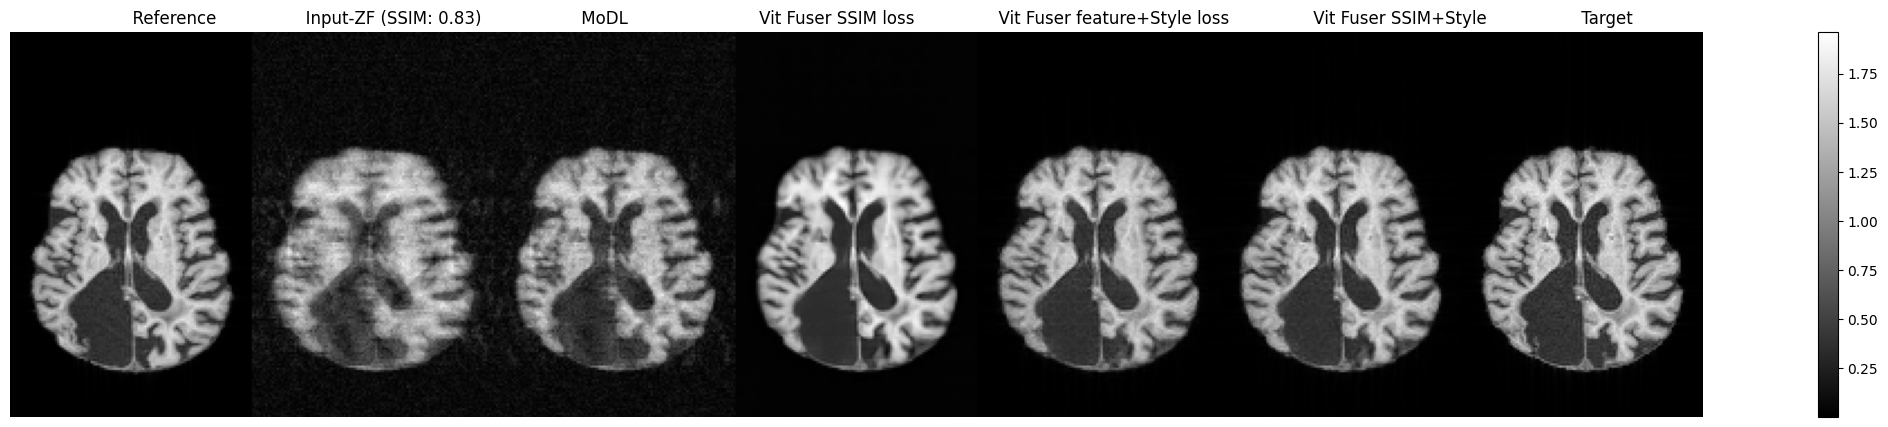

In [11]:
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import binary_fill_holes
def compute_psnr(img1, img2, maxval):
    """Computes PSNR in dB"""
    mse = np.mean((img1 - img2) ** 2)

    return (10 * np.log10(maxval / mse)).item()
cplx_image_target = target
cplx_image_in = img_padded_np
cplx_image_out_vit = im_out_vit
cplx_image_out_vit_ft = im_out_vit_ft
cplx_image_out_vit_ft_test = im_out_vit_ft_test
cplx_image_out_MoDL = im_out_MoDL

cplx_image_reference = ref_np
maxval = np.max(np.abs(np.concatenate((cplx_image_target,cplx_image_in,cplx_image_out_vit,cplx_image_out_vit_ft,cplx_image_out_MoDL,cplx_image_out_vit_ft_test),axis=0)))
minval = np.min(np.abs(np.concatenate((cplx_image_target,cplx_image_in,cplx_image_out_vit,cplx_image_out_vit_ft,cplx_image_out_MoDL,cplx_image_out_vit_ft_test),axis=0)))

target_numpy_norm = np.abs(cplx_image_target)/maxval
input_numpy_norm = np.abs(cplx_image_in)/maxval
ViT_numpy_norm = np.abs(cplx_image_out_vit)/maxval
ViT_style_numpy_norm = np.abs(cplx_image_out_vit_ft)/maxval
ViT_style_test_numpy_norm = np.abs(cplx_image_out_vit_ft_test)/maxval
MoDL_numpy_norm = np.abs(cplx_image_out_MoDL)/maxval

# Area calib
# Find comparison area:
area = target_numpy_norm > 0.30
kernel = np.ones((10, 10)) / 25.0
#area = np.convolve(area, kernel, mode='constant', cval=0.0)
area = scipy.ndimage.convolve(area.astype(float), kernel, mode='constant', cval=0.0)
area[area>0.009] = 1
structuring_element = np.ones((4,4))
area = binary_closing(area, structure=structuring_element)
area = binary_fill_holes(area)

target_numpy_norm = target_numpy_norm * area
input_numpy_norm = input_numpy_norm * area
ViT_numpy_norm = ViT_numpy_norm * area
ViT_style_numpy_norm = ViT_style_numpy_norm * area
ViT_style_test_numpy_norm = ViT_style_test_numpy_norm * area
MoDL_numpy_norm = MoDL_numpy_norm  * area

data_range = maxval - minval
ssim_in, _ = ssim(target_numpy_norm, input_numpy_norm, data_range=data_range, full=True)
ssim_ViT, _ = ssim(target_numpy_norm, ViT_numpy_norm, data_range=data_range, full=True)
ssim_ViT_style, _ = ssim(target_numpy_norm, ViT_style_numpy_norm, data_range=data_range, full=True)
ssim_ViT_style_test, _ = ssim(target_numpy_norm, ViT_style_test_numpy_norm, data_range=data_range, full=True)
ssim_MoDL, _ = ssim(target_numpy_norm, MoDL_numpy_norm, data_range=data_range, full=True)

"""
# Create a figure and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs[0].imshow(np.flipud(np.abs(cplx_image_in)), cmap='gray')
axs[0].set_title('Input')
fig.colorbar(im1, ax=axs[0])
im2 = axs[1].imshow(np.flipud(np.abs(cplx_image_out)), cmap='gray')
axs[1].set_title('Output')
fig.colorbar(im2, ax=axs[1])
im3 = axs[2].imshow(np.flipud(np.abs(cplx_image_target)), cmap='gray')
axs[2].set_title('Target')
fig.colorbar(im3, ax=axs[2])
plt.tight_layout()
plt.show()
"""
print(cplx_image_out_vit.shape)
plt_concat = np.concatenate((np.abs(cplx_image_reference),np.abs(cplx_image_in),np.abs(cplx_image_out_MoDL),np.abs(cplx_image_out_vit),np.abs(cplx_image_out_vit_ft),np.abs(cplx_image_out_vit_ft_test),np.abs(cplx_image_target)),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(30, 5))  # 1 row, 3 columns
im = axs.imshow(plt_concat, cmap='gray')
#axs.set_title(f'       Reference              Input-ZF (SSIM: {ssim_in:.2f})              MoDL (SSIM: {ssim_MoDL:.2f})                    Vit Fuser SSIM loss (SSIM: {ssim_ViT:.2f})               Vit Fuser feature+Style loss (SSIM: {ssim_ViT_style:.2f})                Vit Fuser SSIM+Style loss(SSIM: {ssim_ViT_style_test:.2f})              Target')
axs.set_title(f'          Reference                 Input-ZF (SSIM: {ssim_in:.2f})                   MoDL                         Vit Fuser SSIM loss                Vit Fuser feature+Style loss                Vit Fuser SSIM+Style                  Target')
#axs.set_title(f'Reference                         Input                         Output                                 Target')
fig.colorbar(im, ax=axs)
plt.axis('off')
plt.show()




In [12]:
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=64,normalize=True,input_img_size=(3, 172, 108))
print(cplx.to_tensor(np.abs(cplx_image_target)).permute(2,0,1).unsqueeze(0).shape)
zeros_vec = torch.zeros((1,1,172,108))
tar = torch.cat((cplx.to_tensor(np.abs(cplx_image_target)).permute(2,0,1).unsqueeze(0),zeros_vec),dim=1)
fid.update(tar, real=True)

# SSIM recon
SSIM_recon = torch.cat((cplx.to_tensor(np.abs(cplx_image_out_vit)).permute(2,0,1).unsqueeze(0),zeros_vec),dim=1)
fid.update(SSIM_recon, real=False)
print(f'SSIM recon: ')
fid.compute()


torch.Size([1, 2, 172, 108])
SSIM recon: 


RuntimeError: More than one sample is required for both the real and fake distributed to compute FID

In [ ]:

print(cplx_image_target.shape)
print(cplx_image_in.shape)
print(cplx_image_out.shape)
# Create a figure and axes
kspace_in = cplx.to_numpy(kspace_torch)
kspace_out = cplx.to_numpy(T.fft2((cplx.to_tensor(cplx_image_out))))
kspace_target = cplx.to_numpy(T.fft2((cplx.to_tensor(cplx_image_target))))

plt_concat = np.concatenate((kspace_in,kspace_out,kspace_target),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(15, 5))  # 1 row, 3 columns
im = axs.imshow(np.log(np.abs(plt_concat)), cmap='gray')
axs.set_title('Input                               Output                              Target')
fig.colorbar(im, ax=axs)
plt.show()

pl.ImagePlot(np.log(np.abs(plt_concat).astype(float)))

(172, 108)
(172, 108)


NameError: name 'cplx_image_out' is not defined

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage import img_as_float

####### Errors calculation #######

# Assuming img1 and img2 are PIL images or numpy arrays
# Convert PIL images to numpy arrays if needed
img_target = img_as_float(np.abs(cplx_image_target).copy())/np.max(np.abs(cplx_image_target))
img_in = img_as_float(np.abs(cplx_image_in)/np.max(cplx_image_in))/np.max(np.abs(cplx_image_in))
img_out = img_as_float(np.abs(cplx_image_out).copy())/np.max(np.abs(cplx_image_out))
img_reference = img_as_float(np.abs(cplx_image_reference).copy())/np.max(np.abs(cplx_image_reference))

####### Errors calculation #######

print(f'MSE input: {np.mean(np.abs(cplx_image_in-cplx_image_target)**2)}')
print(f'MSE output: {np.mean(np.abs(cplx_image_out-cplx_image_target)**2)}')

print(f'PSNR input: {T.PSNR(target_torch.cpu(), T.ifft2(kspace_torch.cpu()))}')
print(f'PSNR output: {T.PSNR(target_torch.cpu(), im_out.cpu().unsqueeze(0))}')

# Calculate SSIM values
data_range = img_target.max() - img_target.min()
#ssim_in, _ = ssim(img_target, img_in, data_range=data_range, full=True)
#ssim_out, _ = ssim(img_target, img_out, data_range=data_range, full=True)
cplx_im_out = cplx.to_numpy(im_out.cpu())
image_out = np.abs(cplx_im_out) / np.max(np.abs(cplx_im_out))
cplx_im_in = cplx.to_numpy( T.ifft2(kspace_torch.cpu()))
im_in = np.abs(cplx_im_in).squeeze(0) / np.max(np.abs(cplx_im_in))
cplx_im_target = cplx.to_numpy( target_torch.cpu())
im_target = np.abs(cplx_im_target) / np.max(np.abs(cplx_im_target))
data_range = im_target.max() - im_target.min()

print(im_target.shape)
print(im_in.shape)
ssim_in, _ = ssim(im_target, im_in, data_range=data_range, full=True)
ssim_out, _ = ssim(im_target, image_out, data_range=data_range, full=True)

print(f"SSIM input: {ssim_in:.4f}")
print(f"SSIM output: {ssim_out:.4f}")


MSE input: 0.6272815105332132
MSE output: 0.6327935457229614


IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)